# Generative and Discriminative Models

The goal of this practical is to qualitatively reproduce some of the experimental results in this paper :

**On Discriminative vs. Generative classifiers:  A comparison of logistic regression
and naive Bayes** (*Andrew Y. Ng and Michael I. Jordan*, 
Advances in Neural Information Processing Systems 2001)

## Task1. implement Naïve Bayes Classifier (NBC)

implement a Naïve Bayes Classifier from scartch using NumPy. 
The classifier should be able to handle binary and continuous features and categorical features. 
Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical. the classifier can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'])

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y \mid \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The **fit** function is to estimate all the parameters ($\theta$ and $\pi$) of the NBC, i.e., train the classifier. The **predict** function is to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability, i.e., make the prediction.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

### 1.1 import libraries

In [1]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

from scipy.stats import norm
from scipy.stats import multivariate_normal, multinomial
from scipy.stats import bernoulli

### 1.2 implement Class-conditional distributions

Before implementing NBC, we first implement the class-conditional distributions $p(\mathbf{x} \mid y, \theta)$. implementation have two functions: **estimate** and **get_log_probability**. 

- The **estimate** function takes data as input and models the data using some distribution $p(x \mid \theta)$, where $\theta$ is the parameters of this distribution. The function estimates the parameters $\theta$ using maximum likelihood estimators (MLE). 
For example, in the case of continuous features, we use the Gaussian distribution to model the data. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data. 

- The **get_log_probability** function takes as input a new data point $x_{new}$ and returns the log of $p(x_{new} \mid \theta)$. For the Gaussian distribution, the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

For different types of features, you need to use different distributions.  

- For **continuous features**: Use Gaussian distribution
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
- For **binary features**: Use Bernoulli distribution 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html
- For **categorical features**: Use Multinoulli distribution (The multinoulli distribution is a special case of the multinomial distribution, where the number of trials is 1)
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multinomial.html

import statistic libraries (e.g., `scipy.stats`) for the implementation of the distributions. 



**Implementation Issues:**
- The probabilities can be very small. To avoid underflow issues, we should compute the log of the probabilities. Read more: (Mur) Chapter 3.5.3 
- The variance for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6. This is to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. 
- Laplace/Additive smoothing: we want to ensure that the estimates for the parameter for the Bernoulli and Multinoulli random variables is never exactly 0 or 1. For this reason we should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).
in this taks, let's set alpha to 1.
- For simplicity, we assume the data values for binary features are integers from {0,1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.


In [2]:
ALPHA = 1.0 # for additive smoothing

# Distribution for continuous features
class ContFeatureParam:
    def estimate(self, X):
        # Estimate the parameters for the Gaussian distribution 
        # so that it best describes the input data X
        # params of Gaussian distribution : mean, var 
        self.mean = np.mean(X)
        self.var = np.var(X)
        
        if self.var == 0:
            self.var == 10**-6

    def get_log_probability(self, X_new):
        # return the log of the density values for the input values X_new
        l_prob = norm.logpdf(X_new, loc=self.mean, scale=self.var)
        
        return l_prob

# Distribution for binary features
class BinFeatureParam:
    def estimate(self, X):
        # Estimate the parameters for the Bernoulli distribution 
        # so that it best describes the input data X
        # X is a vector with binary values
        self.success = np.sum(X,axis=0)
        self.p = (self.success+ALPHA)/(len(X)+2*ALPHA)

    def get_log_probability(self, X_new):
        # return the log of the probability values for the input values X_new
        l_prob = bernoulli.logpmf(X_new, self.p, loc=0)
        return l_prob


# Distribution for categorical features
class CatFeatureParam:
    # we need to know the number of categories for the categorical feature
    def __init__(self, num_of_categories):
        self.n_category = num_of_categories
        self.train_occurs = [0]*self.n_category # prepare a vector with size of n_of_categories
        self.p_category = [] # probability vector along with the order of categories
    
    def estimate(self, X):
        # Estimate the parameters for the Multinoulli distribution 
        # so that it best describes the input data X
       
        # counting occurence of input variables
        for i in X:            
            self.train_occurs[i] += 1 
        
        # fill the p_caterogy vector 
        for occur in self.train_occurs:
            p = (occur+ALPHA)/(len(X)+(self.n_category)*ALPHA)
            self.p_category.append(p)  # we might need a smoothing 

    def get_log_probability(self, X_new):
        # return the log of the probability values for the input values X_new
        occur_vecs = [] # list of one-hot encoding vec 
        
        for i in X_new:
            occur_vec = [0]*self.n_category # create fixed size (n_of_categories) of vec
            occur_vec[i] += 1               # one-hot encoding
            occur_vecs.append(occur_vec)

        l_prob = multinomial.logpmf(occur_vecs, 1, self.p_category)

        return l_prob

**Test**

In [3]:
# continuous features

X = np.array([2.70508547,2.10499698,1.76019132,3.42016431,3.47037973,3.67435061,1.84749286,4.3388506,2.27818252,4.65165335])

param = ContFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3]))
print(probs)

[-5.80509439 -3.08847556 -1.44768796 -0.88273157]


In [4]:
# binary features

X = np.array([0,0,1,1,0,1,0,1,1,1])

param = BinFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1]))
print(probs)

[-0.87546874 -0.5389965 ]


In [5]:
# categorical features (bonus task)

X = np.array([0,6,5,4,0,6,6,4,1,1,2,3,8,8,1,6,4,9,0,2,2,3,8,0,2])

param = CatFeatureParam(num_of_categories=10)
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3,4,5,6,7,8,9]))
print(probs)

[-1.94591015 -2.1690537  -1.94591015 -2.45673577 -2.1690537  -2.86220088
 -1.94591015 -3.55534806 -2.1690537  -2.86220088]


### 1.3 Implement NBC

We are now ready to implement NBC. We follow the structure of models in scikit-learn. We implement NBC as a class with functions **init**, **fit** and **predict**.
The **init** function takes as input the types of features and initialise the classifier. The **fit** function takes the training data as input and estimates the parameters. The **predict** function predicts the label for the input data. 

**Implementation Issues:**
- use matrix operations rather than loops. In general, loops over classes or features are OK, but loops over the rows of data are not a good idea.
- The probabilities can be very small. To avoid underflow issues,do the calculations in log space. Read more: (Mur) Chapter 3.5.3


In [6]:
class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['b', 'r', 'c']
    
    def __init__(self, feature_types=[]):
        self.feature_types = feature_types     
        
    # The function uses the input data to estimate all the parameters of the NBC
    def fit(self, X, y):
        '''
        parameters:
            X : [array] 1*j array of dataset
            y : [array] 1d array of labels 
        '''
        
        self.pis = {}   # key: category, value: pi_c
        self.models= {} # key: category, value: parameterized model for each feature in one category
        
        self.labels,count=np.unique(y,return_counts=True)
  
        # combine X and y into a dataframe
        total_c = len(y)
        d = {'data': list(X), 'y': y}
        df = pd.DataFrame(data=d)
        
        # learn parameters for each feature j per category c 
        for i, label in enumerate(self.labels):
            # 1. calculate pi_c per categories (num_variables_in_c/total_variables)
            pi_c = count[i]/total_c
            self.pis[label] = pi_c
            
            df_c = df[y==label] # slice dataframe corresponding the category (label)
            x_c = df_c['data']  # list of dataset rows in category c
            
            models =[] # parameterized model with the ordered of features (colums j)
            
            # 2. calculate theta for each feature j
            for j, feature in enumerate(self.feature_types):
                x_jc = [x[j] for x in x_c] # extract value of jth colum (feature)
                if feature == 'r':
                    model = ContFeatureParam()
                    model.estimate(x_jc)
                    models.append(model)
                elif feature == 'b':
                    model = BinFeatureParam()
                    model.estimate(x_jc)
                    models.append(model)
                elif feature == 'c':
                    max_cat = max(X[:,j])
                    num_of_categories = max_cat + 1
                    model = CatFeatureParam(num_of_categories)
                    model.estimate(x_jc)
                    models.append(model)
            self.models[label] = models
            
                
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):  
        '''
        parameters:
            X      : [array] n*d array of unseend dataset 
            
        return
            y_hats : [list] list of predicted labels
        '''
        p_cs = [] # c*d array, c number of list consist of list of p_c of each datapoint
        
        # 1. calculating class-conditional distribution
        for i, label in enumerate(self.labels):
            
            # prepare n size of vector to sum up the probability colunmwise 
            pi_c = math.log(self.pis[label])
            p_c = [pi_c]*len(X) # p = log(pi_c) + sum(log(p_feature))
            
            #2. calculating p(x|theta) feature by featrue
            for j, feature in enumerate(self.feature_types):
                x_new_j = X[:,j]
                
                p_c += self.models[label][j].get_log_probability(x_new_j)
                
            p_cs.append(p_c)
        
        p_cs = np.transpose(p_cs) # n*c array (list of c probabilty for each label of each datapoint)
        y_hats = [np.argmax(p_c) for p_c in p_cs] # pick the maximum probability among the possible catecories
        
        return y_hats
                

**Tests**

In [7]:
# All features of the iris dataset are continuous.

from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'])
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 90%
print(yhat)
#print(list(ytest))

Accuracy: 0.9333333333333333
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [8]:
# All features of this dataset are binary
import pandas as pd
data = pd.read_csv('binary_test.csv', header=None)
data = data.to_numpy()

X = data[:,1:]
y = data[:,0]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['b'] * 16)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 85%
print(yhat)

Accuracy: 0.8723404255319149
[1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]


In [9]:
# All features of this dataset are categorical (bonus task)

data = pd.read_csv('categorical_test.csv', header=None)
data = data.to_numpy()

X = data[:,:-1]
y = data[:,-1]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['c'] * 9)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 65%
print(yhat) 

Accuracy: 0.6896551724137931
[0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


## Task2. Compare NBS and Logistic Regression
For logistic regression, use the implementation in scikit-learn.

In [10]:
from sklearn.linear_model import LogisticRegression

### Experiments

The experiment is to compare the classification error of the NBC and LR trained on increasingly larger training datasets. 
Since the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, we will get average test errors as a function of the size of the training data. 


In [11]:
from sklearn.model_selection import train_test_split

def compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10):
  # inputs:
  #   nbc: Naive Bayes Classifier
  #   lr: Logistic Regression Classifier
  #   X, y: data
  #   num_runs: we need repeat num_runs times and store average results
  #   num_splits: we want to compare the two models on increasingly larger training sets.
  #               num_splits defines the number of increasing steps. 
  # outputs:
  #   the arrays of the test errors across the runs of the two classifiers 

    test_errs_nbc = [] # test errors with different ratio of tarining set
    test_errs_lr = []
    
    N, _ = X.shape
    idx_test = int(0.2 * N)
    
    for ratio in range(1,num_splits+1):
        test_err_nbc = 0 # sum of test errors with n times trial
        test_err_lr = 0
        
        idx_split = int(N*(0.1*ratio))

        for i in range(num_runs): 
            # try num_runs different trainset and average the test error 
            shuffler = np.random.permutation(N)
            Xtrain = X[shuffler[:idx_split]]
            ytrain = y[shuffler[:idx_split]]
            Xtest = X[shuffler[-idx_test:]]
            ytest = y[shuffler[-idx_test:]]

            ## nbc
            nbc.fit(Xtrain,ytrain)
            yhat_nbc = nbc.predict(Xtest)
            test_err_nbc += np.mean(yhat_nbc != ytest)
            
            # lr 
            lr.fit(Xtrain,ytrain)
            yhat_lr = lr.predict(Xtest)
            test_err_lr += np.mean(yhat_lr != ytest)
            
        test_errs_nbc.append(test_err_nbc/num_runs)
        test_errs_lr.append(test_err_lr/num_runs)
    
    return test_errs_nbc, test_errs_lr


In [12]:
def makePlot(nbc_perf, lr_perf, title=None, num_splits=10):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * (100/num_splits) for i in range(num_splits)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

For each dataset,
1. prepare the data for the two classifiers, e.g., handle missing values, handle text/categorical data, etc.
2. compare the two classifiers on the dataset and generate the plots
3. write a short report of how you prepare the data and your observations of the comparison 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

In [ ]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler

# Load sklearn iris dataset and convert it to dataframe
iris = load_iris()

df_iris = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

# Split df to X and y
X = df_iris.drop("target", axis=1).to_numpy()
y = iris["target"]
    
# Normalize dataset
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Prepare the models and calculate test errors 
NBC_iris = NBC(feature_types=['r','r','r','r'])
LR_iris = LogisticRegression()

error_nbc_iris, error_lr_iris = compareNBCvsLR(NBC_iris, LR_iris, X, y, num_runs=200, num_splits=10)

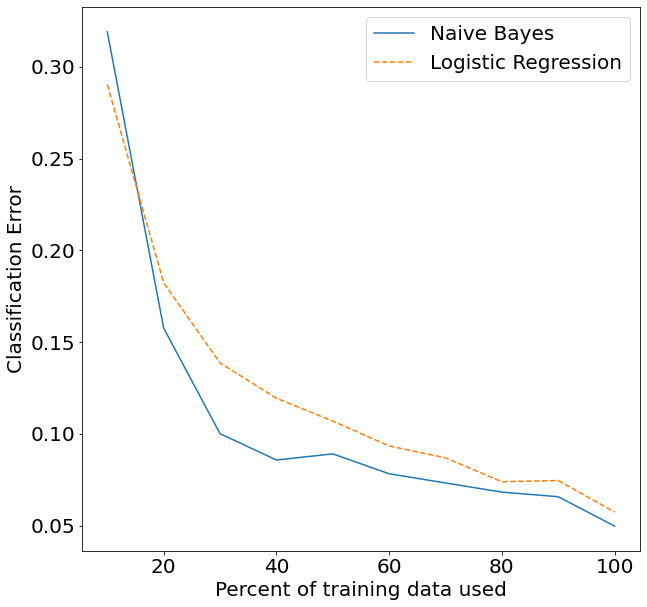

In [15]:
makePlot(error_nbc_iris, error_lr_iris)

**Interpretation**  

The data is transformed using the MinMaxScaler. In a given size of continuous dataset, overall the generative naive Bayes model has lower classfication error and approaches its asymptotic error faster. However, since both classification errors of the discriminative logistic regression model and the generative naive Bayes model are decreasing, it might be good to test with larger dataset to see where they converge and if logistic regression surpasses the performance of naive Bayes or not.

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records

The logistic regression line meets the naive bayes line early in the plot. To see it clearer, you should use only 100 data points from the dataset for this experiment.

In [16]:
from sklearn.preprocessing import OrdinalEncoder

In [18]:
# 1. load data and drop missing values
df_voting = pd.read_csv('voting.csv')
df_voting.dropna(inplace=True)

# 2. split df to x and y
X = df_voting.drop("label", axis=1)
y = df_voting['label'].to_numpy()

N, _ = X.shape
features = X.columns

# 3. encoding X and y 
ordinal_encoder = OrdinalEncoder()

for col in features:
    X[col] = ordinal_encoder.fit_transform(np.array(X[col]).reshape(-1,1))
    
enc_X = X.to_numpy()
enc_y = (ordinal_encoder.fit_transform(y.reshape(-1,1))).flatten()

# 4. pick only 100 data point 
shuffler = np.random.permutation(N)
X_100 = enc_X[shuffler[:100]]
y_100 = enc_y[shuffler[:100]]

# 5. prepare the model
NBC_voting = NBC(feature_types=['b']*16)
LR = LogisticRegression()

error_nbc_voting, error_lr_voting = compareNBCvsLR(NBC_voting, LR, X_100, y_100, num_runs=200, num_splits=10)


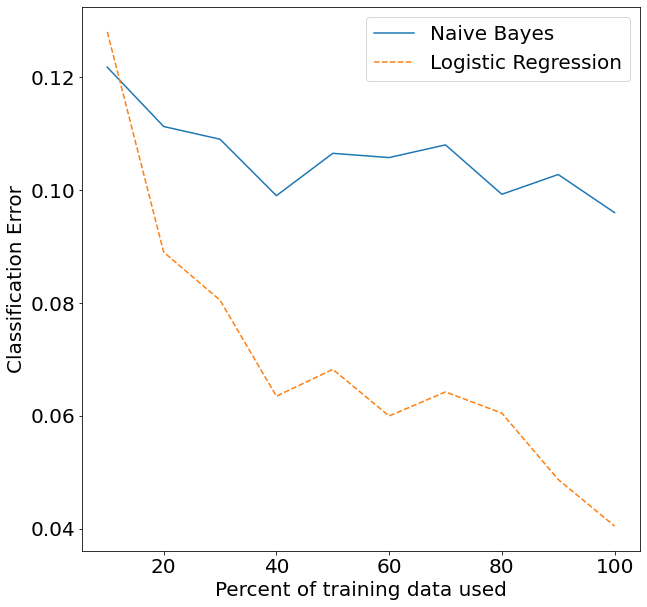

In [19]:
makePlot(error_nbc_voting, error_lr_voting)

**Interpretation**  
For the voting data set, the data is prepared by dropping na values, and fitting an ordinal encoder for each feature. Initially, it looks like the Naïve Bayes Classifier does better. However, as the percentage of training data is increased, the discriminative Logistic Regression model eventually catches up and overtakes the performance of the Naïve Bayes model.